In [69]:
# from google.colab import drive

# # This will prompt you to click a link and get an authorization code
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !pip install tsfresh
# !pip install catboost


In [71]:

import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.signal import find_peaks
import numpy as np
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_error


from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters

os.chdir("/content/gdrive/MyDrive/DMP") #add the path accordingly
pd.set_option("display.precision", 2)

In [74]:
df = pd.read_pickle("merged_dataset/P12/ALL.pkl")
df['active energy (kJ)'][-10:-1]

Time
2021-12-03 11:38:34    0.40
2021-12-03 11:38:35    0.40
2021-12-03 11:38:36    0.40
2021-12-03 11:38:37    0.40
2021-12-03 11:38:38    0.40
2021-12-03 11:38:39    0.40
2021-12-03 11:38:40    0.40
2021-12-03 11:38:41    0.39
2021-12-03 11:38:42    0.39
Name: active energy (kJ), dtype: float64

In [75]:

import pandas as pd

people = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17']
columns_needed = ["Time[s]", "Delta_Time","MET", "active energy (kJ)"]

def time_lagged_features(data, time_lags):
    for time_lag in time_lags:
        data['active energy_lag_b_{}'.format(time_lag)] = data['active energy (kJ)'].shift(time_lag)
        data['active energy_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)

        # Now create the forward lagged features
        data['active energy_lag_f_{}'.format(time_lag)] = data['active energy (kJ)'].shift(-time_lag)
        data['active energy_lag_f_{}'.format(time_lag)].fillna(method='ffill', inplace=True)
    return data

time_lagged_features_enabled = True

data = []
for person in people:
    df = pd.read_pickle("merged_dataset/{0}/ALL.pkl".format(person))
    df_subset = df[columns_needed]
    df_subset.ffill(inplace=True)
    df_subset.bfill(inplace=True)

    if time_lagged_features_enabled:
        time_lags = [x for x in range(1, 15, 2)]
        df_subset = time_lagged_features(df_subset, time_lags)

    coulms_feature_eng = ["active energy (kJ)", "Time[s]"]
    features = extract_features(df_subset[coulms_feature_eng], column_id='Time[s]',
                                 default_fc_parameters=MinimalFCParameters(),
                                 n_jobs=4)

    # Merge features back into the original DataFrame
    df_subset = df_subset.merge(features, left_on='Time[s]', right_index=True)

    df_subset['Person'] = person
    data.append(df_subset)


print(data[0])


<ipython-input-75-5173351d7049>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.ffill(inplace=True)
<ipython-input-75-5173351d7049>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.bfill(inplace=True)
<ipython-input-75-5173351d7049>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['active energy_lag_b_{}'.format(time_lag)] = data['active energy (kJ)'].

                     Time[s]      Delta_Time   MET  active energy (kJ)  \
Time                                                                     
2021-12-03 16:58:51      1.0 0 days 00:00:00  1.31                0.25   
2021-12-03 16:58:52      2.0 0 days 00:00:01  1.31                0.25   
2021-12-03 16:58:53      3.0 0 days 00:00:02  1.52                0.25   
2021-12-03 16:58:54      4.0 0 days 00:00:03  1.63                0.25   
2021-12-03 16:58:55      5.0 0 days 00:00:04  1.56                0.25   
...                      ...             ...   ...                 ...   
2021-12-03 17:28:48   1798.0 0 days 00:29:57  5.32                0.68   
2021-12-03 17:28:49   1799.0 0 days 00:29:58  5.11                0.68   
2021-12-03 17:28:50   1800.0 0 days 00:29:59  4.46                0.68   
2021-12-03 17:28:51   1801.0 0 days 00:30:00  4.12                0.68   
2021-12-03 17:28:52   1802.0 0 days 00:30:01  4.43                0.68   

                     active energy_la

In [76]:
data[0]

,Time[s],Delta_Time,MET,active energy (kJ),active energy_lag_b_1,active energy_lag_f_1,active energy_lag_b_3,active energy_lag_f_3,active energy_lag_b_5,active energy_lag_f_5,...,active energy (kJ)__median,active energy (kJ)__mean,active energy (kJ)__length,active energy (kJ)__standard_deviation,active energy (kJ)__variance,active energy (kJ)__root_mean_square,active energy (kJ)__maximum,active energy (kJ)__absolute_maximum,active energy (kJ)__minimum,Person
Time,,,,,,,,,,,,,,,,,,,,,
2021-12-03 16:58:51,1.0,0 days 00:00:00,1.31,0.25,0.25,0.25,0.25,0.25,0.25,0.25,...,0.25,0.25,1.0,0.0,0.0,0.25,0.25,0.25,0.25,P1
2021-12-03 16:58:52,2.0,0 days 00:00:01,1.31,0.25,0.25,0.25,0.25,0.25,0.25,0.25,...,0.25,0.25,1.0,0.0,0.0,0.25,0.25,0.25,0.25,P1
2021-12-03 16:58:53,3.0,0 days 00:00:02,1.52,0.25,0.25,0.25,0.25,0.25,0.25,0.27,...,0.25,0.25,1.0,0.0,0.0,0.25,0.25,0.25,0.25,P1
2021-12-03 16:58:54,4.0,0 days 00:00:03,1.63,0.25,0.25,0.25,0.25,0.25,0.25,0.28,...,0.25,0.25,1.0,0.0,0.0,0.25,0.25,0.25,0.25,P1
2021-12-03 16:58:55,5.0,0 days 00:00:04,1.56,0.25,0.25,0.25,0.25,0.27,0.25,0.28,...,0.25,0.25,1.0,0.0,0.0,0.25,0.25,0.25,0.25,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03 17:28:48,1798.0,0 days 00:29:57,5.32,0.68,0.68,0.68,0.69,0.68,0.69,0.68,...,0.68,0.68,1.0,0.0,0.0,0.68,0.68,0.68,0.68,P1
2021-12-03 17:28:49,1799.0,0 days 00:29:58,5.11,0.68,0.68,0.68,0.68,0.68,0.69,0.68,...,0.68,0.68,1.0,0.0,0.0,0.68,0.68,0.68,0.68,P1
2021-12-03 17:28:50,1800.0,0 days 00:29:59,4.46,0.68,0.68,0.68,0.68,0.68,0.69,0.68,...,0.68,0.68,1.0,0.0,0.0,0.68,0.68,0.68,0.68,P1


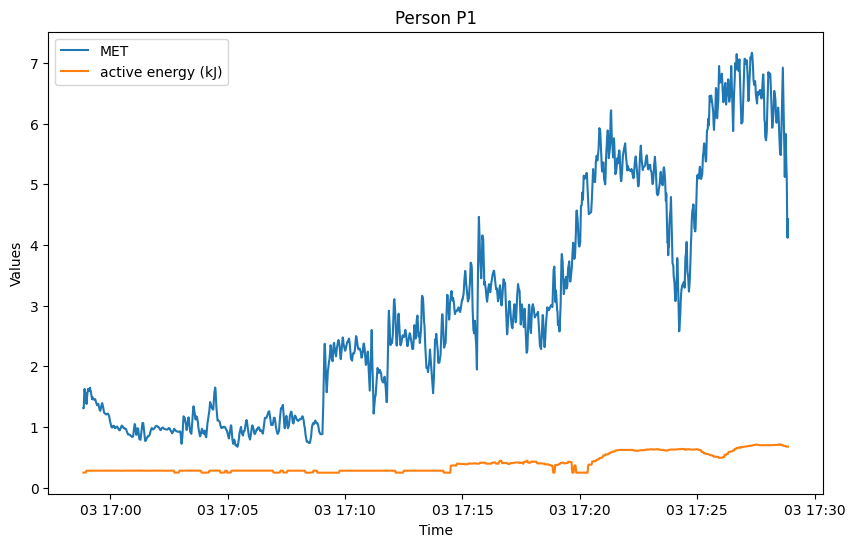

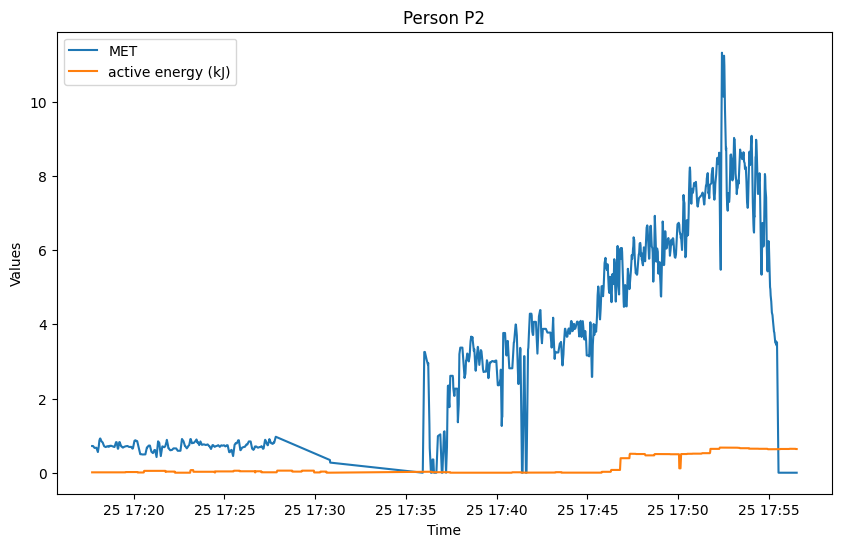

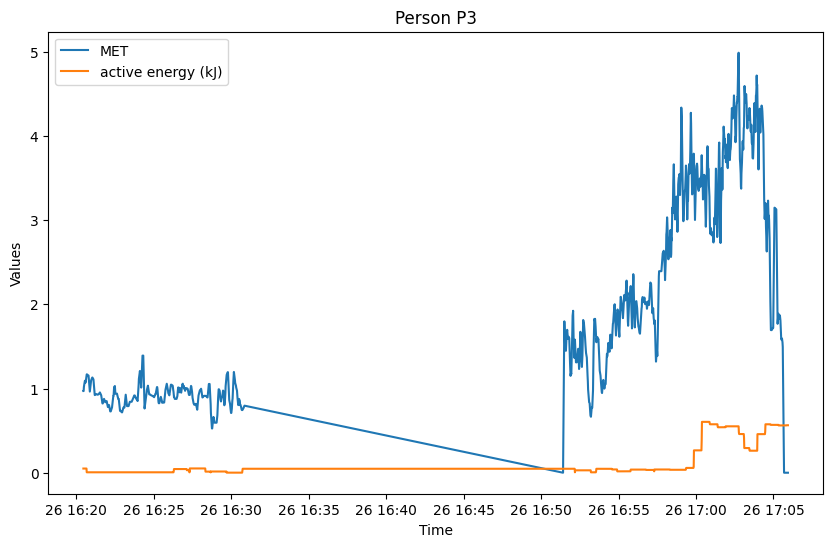

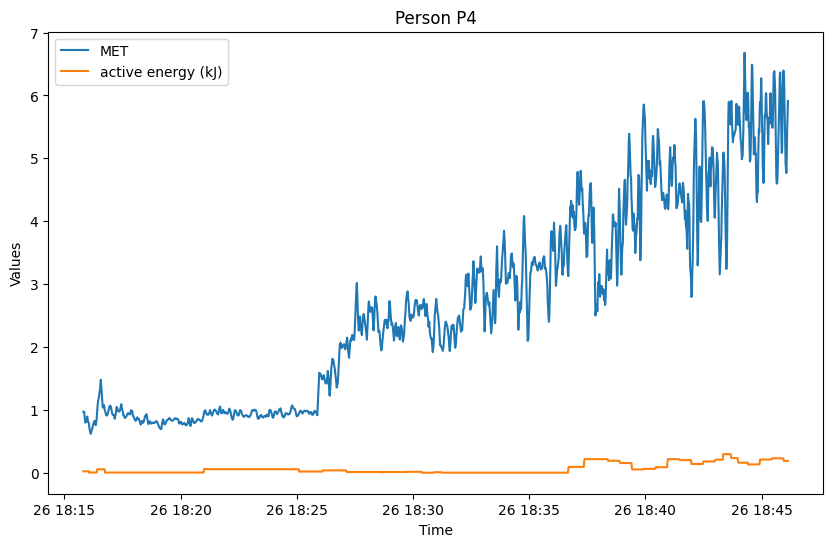

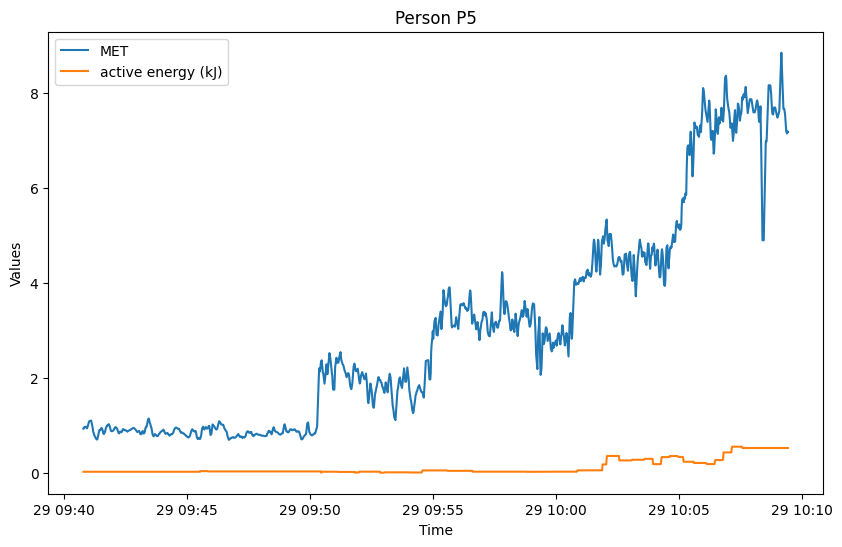

In [77]:
import matplotlib.pyplot as plt

# Iterate over the data list
for i, df_subset in enumerate(data):
  if i < 5:
    person = people[i]

    # Extract MET and value__bpm columns
    MET = df_subset['MET']
    active_energy = df_subset['active energy (kJ)'].ffill()

    # Plot MET and value__bpm
    plt.figure(figsize=(10, 6))
    plt.plot(MET, label='MET')
    plt.plot(active_energy, label='active energy (kJ)')
    plt.title(f'Person {person}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


## Model training

### Train/test splitting

In [78]:
concatenated_data = pd.concat(data, axis=0)
data_new = concatenated_data.copy()

X_data = data_new.drop(columns=["Delta_Time", "MET", "Time[s]", "Person"]).copy()
print(X_data.columns)
X_data = X_data.to_numpy()

Y_data = concatenated_data['MET']
Y_data = Y_data.to_numpy()
people = concatenated_data['Person']

Index(['active energy (kJ)', 'active energy_lag_b_1', 'active energy_lag_f_1',
       'active energy_lag_b_3', 'active energy_lag_f_3',
       'active energy_lag_b_5', 'active energy_lag_f_5',
       'active energy_lag_b_7', 'active energy_lag_f_7',
       'active energy_lag_b_9', 'active energy_lag_f_9',
       'active energy_lag_b_11', 'active energy_lag_f_11',
       'active energy_lag_b_13', 'active energy_lag_f_13',
       'active energy (kJ)__sum_values', 'active energy (kJ)__median',
       'active energy (kJ)__mean', 'active energy (kJ)__length',
       'active energy (kJ)__standard_deviation',
       'active energy (kJ)__variance', 'active energy (kJ)__root_mean_square',
       'active energy (kJ)__maximum', 'active energy (kJ)__absolute_maximum',
       'active energy (kJ)__minimum'],
      dtype='object')


In [79]:
# concatenated_data = pd.concat(data, axis=0)

# concatenated_data = concatenated_data.dropna()

# X_data = concatenated_data[columns_needed].copy()
# X_data = X_data.to_numpy()

# Y_data = concatenated_data['MET']
# Y_data = Y_data.to_numpy()
# people = concatenated_data['Person']

In [80]:
normalizer = MinMaxScaler()
X_data = normalizer.fit_transform(X_data)

### XGBoost with cross validation

#### Cross validation

In [81]:
group_kfold = GroupKFold(n_splits=17)
cv = [split for split in group_kfold.split(X_data, Y_data, people)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)

In [82]:
for i,group in enumerate(cv):
    print(f"Fold {i}")
    print(f"Train size: {group[0].size}")
    print(f"Test size: {group[1].size}")
    print(f"Train participants: {people.iloc[group[0]].unique()}")
    print(f"Test participants: {people.iloc[group[1]].unique()}")

Fold 0
Train size: 25854
Test size: 1802
Train participants: ['P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P1']
Fold 1
Train size: 25630
Test size: 2026
Train participants: ['P1' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P2']
Fold 2
Train size: 26159
Test size: 1497
Train participants: ['P1' 'P2' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P3']
Fold 3
Train size: 25836
Test size: 1820
Train participants: ['P1' 'P2' 'P3' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P4']
Fold 4
Train size: 25937
Test size: 1719
Train participants: ['P1' 'P2' 'P3' 'P4' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P5']
Fold 5
Train size: 26006
Test size: 1650
Train participants: ['P1' 'P2' 'P3' 'P4' 'P5' 'P7' 'P8' 'P9' 'P10' 'P

In [87]:

parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.001, 0.002, 0.004, 0.005, 0.01],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create XGBRegressor model
model = XGBRegressor(colsample_bytree=0.56, subsample=0.3, min_child_weight=0.6)

# Define GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=17)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search with custom CV splitter
grid_search = GridSearchCV(model, parameters_grid, cv=group_kfold.split(X_data, Y_data, people), scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


Best parameters found:
{'learning_rate': 0.004, 'max_depth': 3, 'n_estimators': 1000}
Best mean absolute error found: 1.2026995325633993


P1


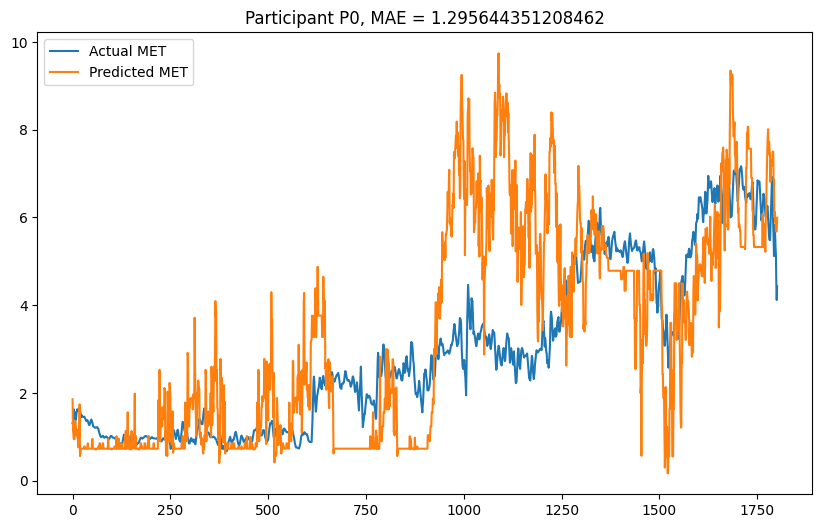

P1


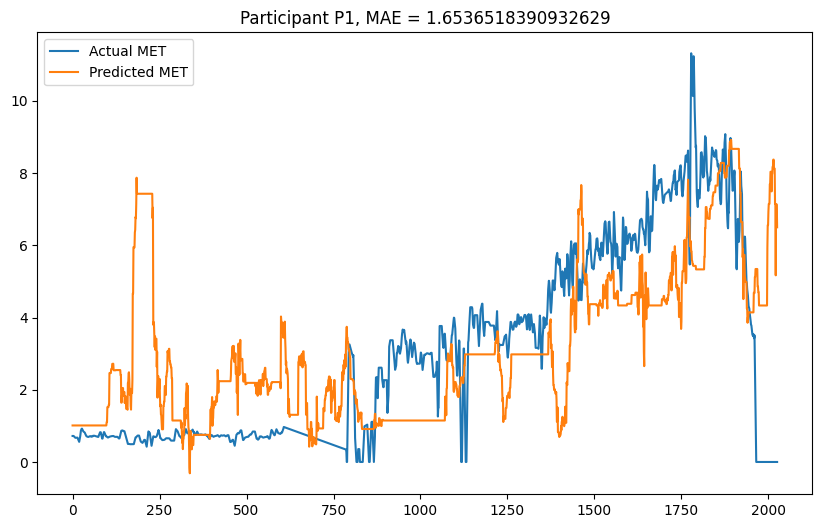

P1


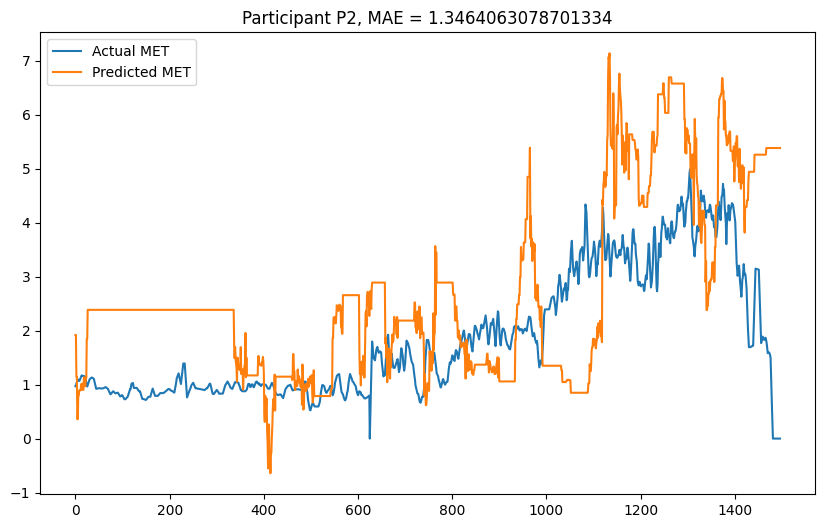

P1


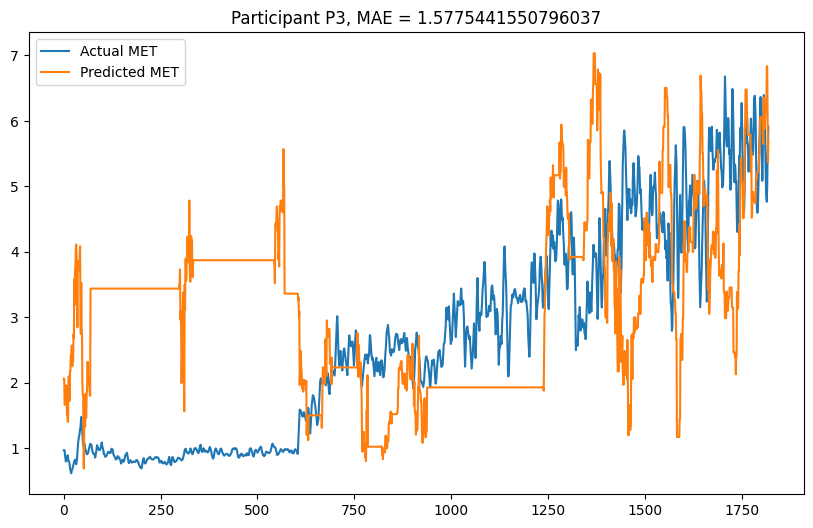

P1


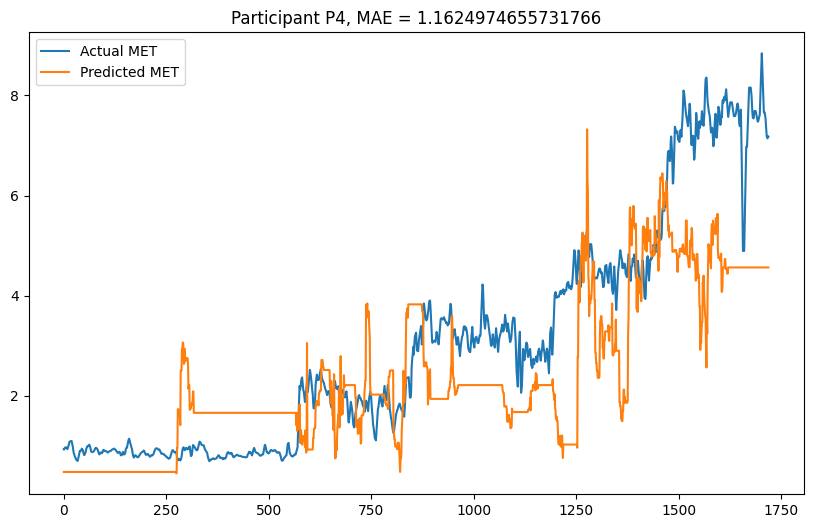

P1


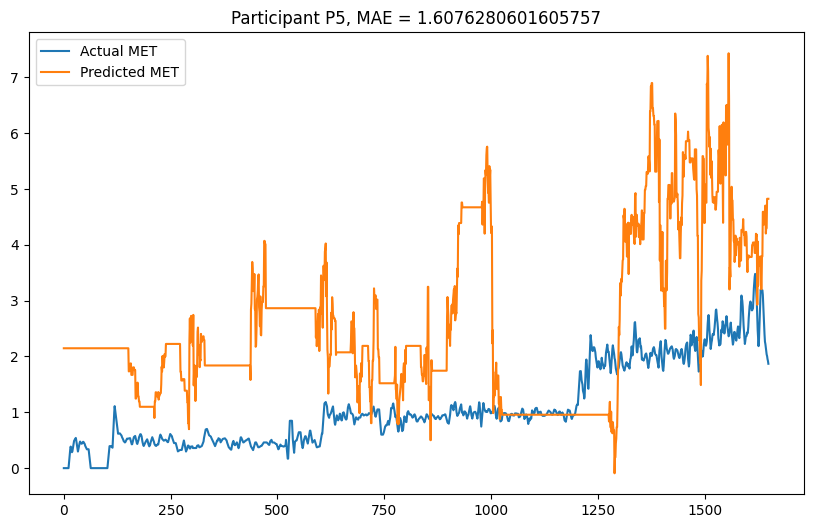

P1


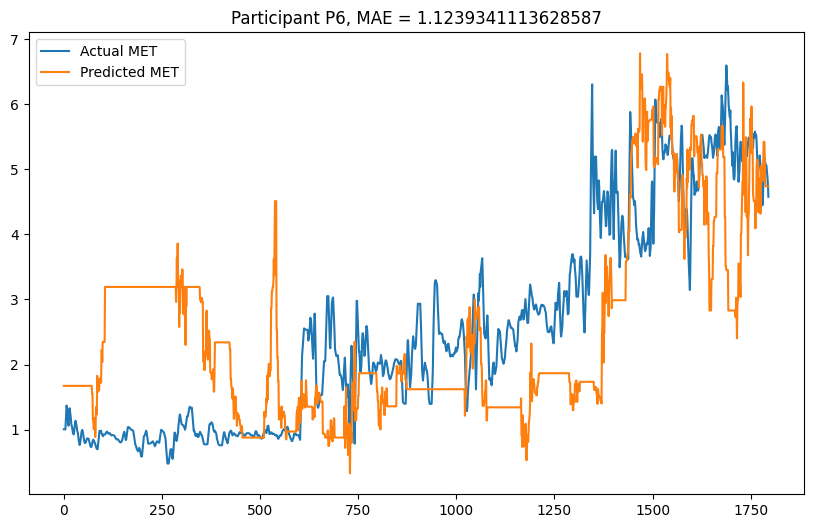

P1


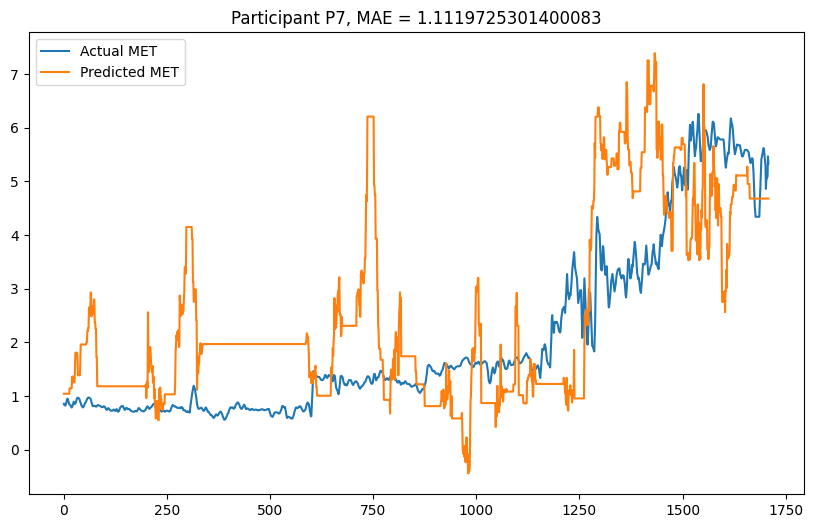

P1


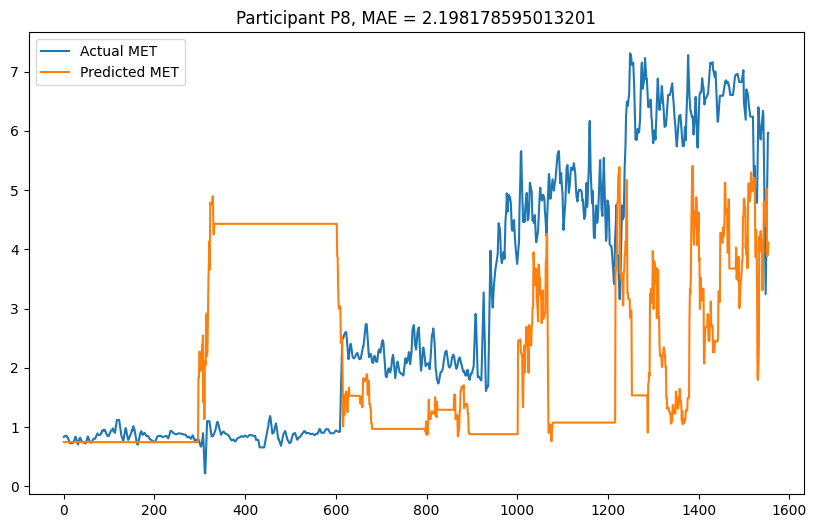

P1


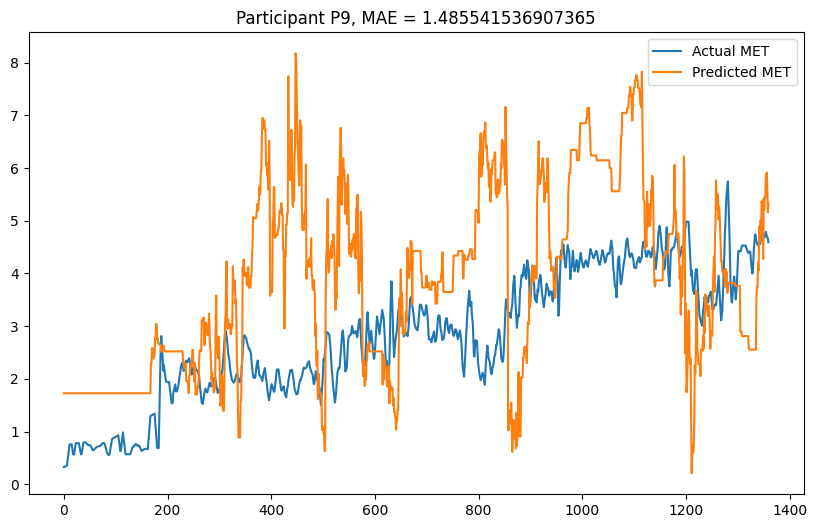

P1


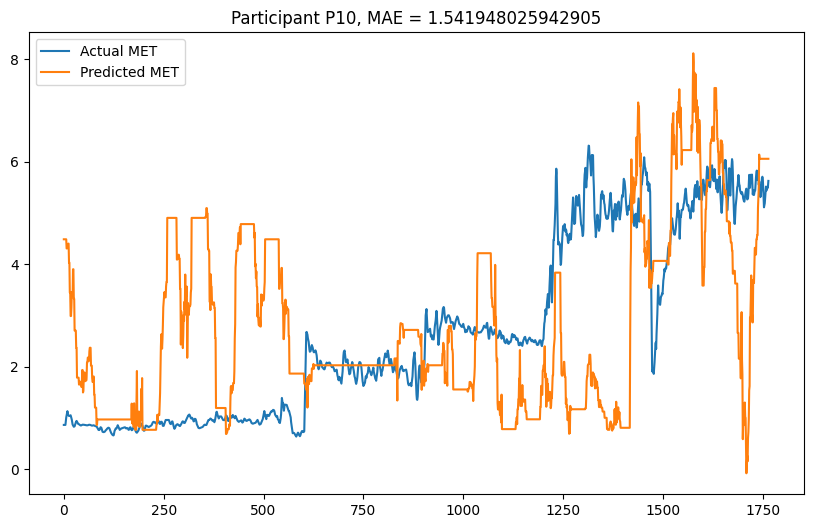

P1


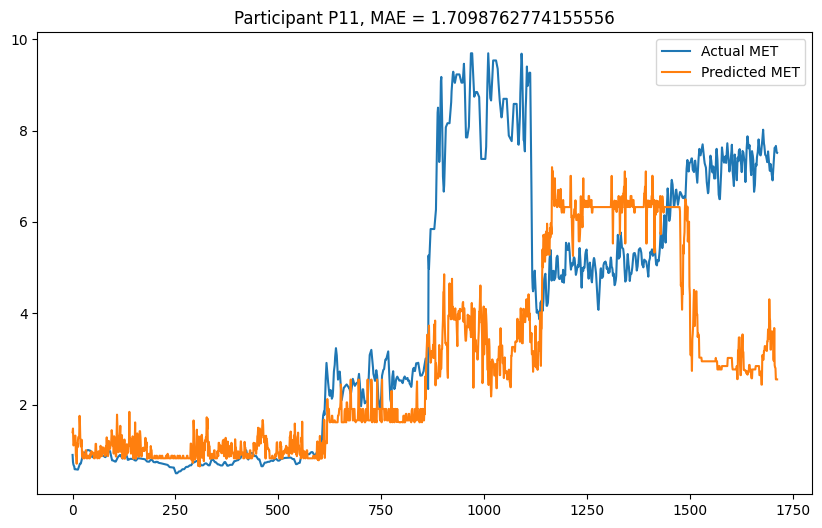

P1


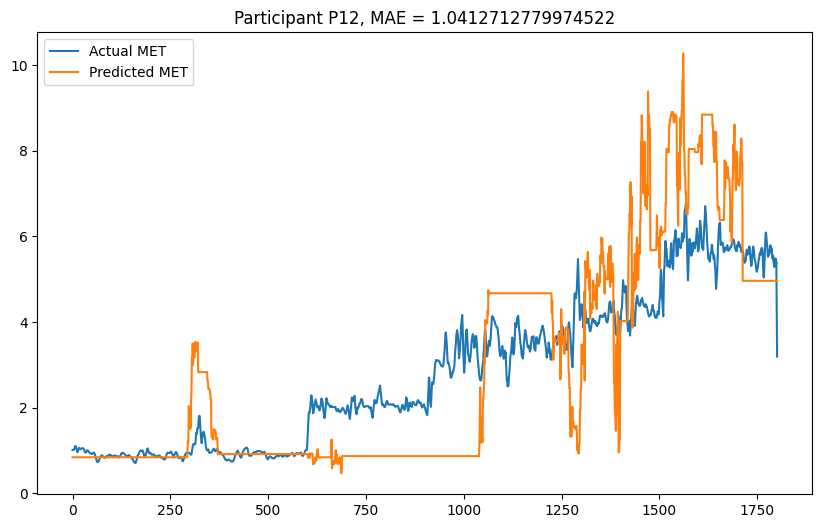

P1


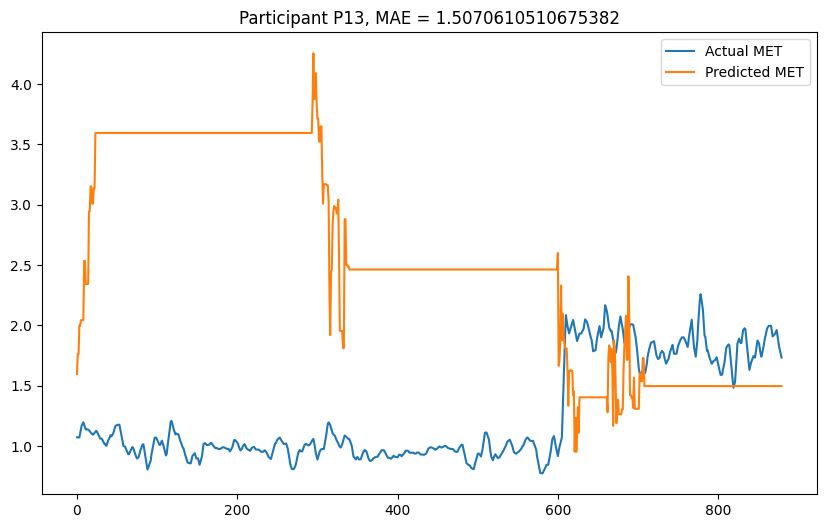

P1


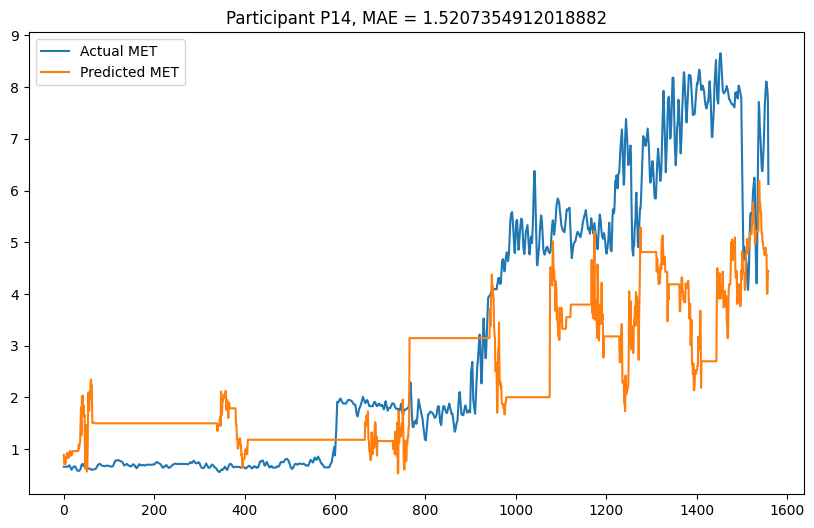

P1


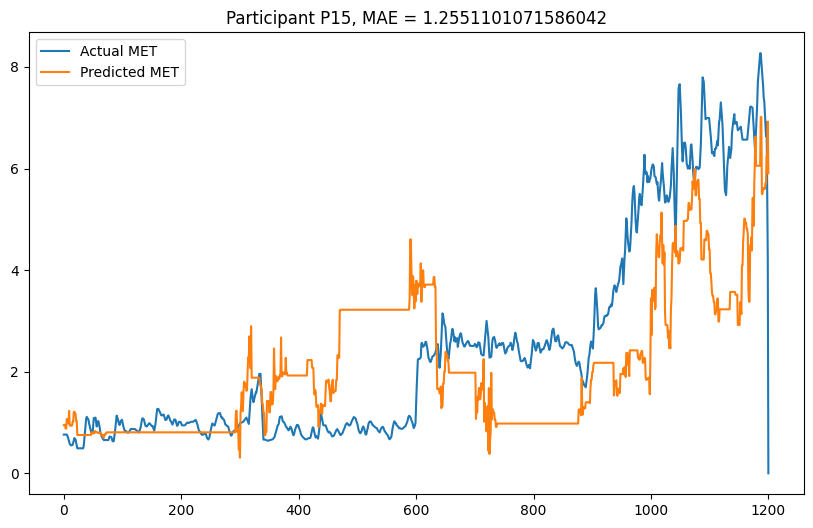

P1


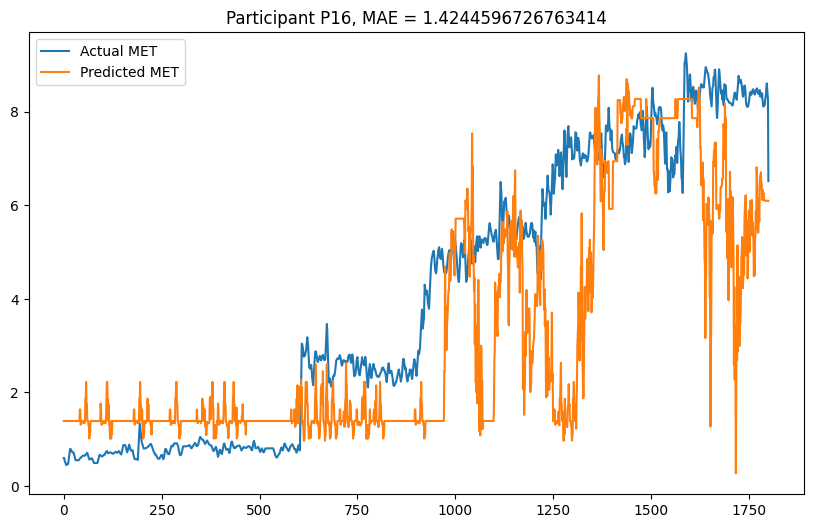

In [88]:
# print(cv)
mae_list_xgboost =[]
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    print(people[fold])

    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]

    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    mae = mean_absolute_error(Y_test, Y_pred)
    mae_list_xgboost.append((fold + 1,mae))

    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant P{}, MAE = {}'.format(fold, mae))
    plt.legend()
    plt.show()


In [89]:
mae_list_xgboost

[(1, 1.295644351208462),
 (2, 1.6536518390932629),
 (3, 1.3464063078701334),
 (4, 1.5775441550796037),
 (5, 1.1624974655731766),
 (6, 1.6076280601605757),
 (7, 1.1239341113628587),
 (8, 1.1119725301400083),
 (9, 2.198178595013201),
 (10, 1.485541536907365),
 (11, 1.541948025942905),
 (12, 1.7098762774155556),
 (13, 1.0412712779974522),
 (14, 1.5070610510675382),
 (15, 1.5207354912018882),
 (16, 1.2551101071586042),
 (17, 1.4244596726763414)]

In [90]:
averages = tuple(sum(col) / len(mae_list_xgboost) for col in zip(*mae_list_xgboost))
print("Averages:", averages)

Averages: (9.0, 1.4449094621099374)


In [93]:
print(' & '.join("{:.2f}".format(t[1]) for t in mae_list_xgboost))

1.30 & 1.65 & 1.35 & 1.58 & 1.16 & 1.61 & 1.12 & 1.11 & 2.20 & 1.49 & 1.54 & 1.71 & 1.04 & 1.51 & 1.52 & 1.26 & 1.42
